In [20]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as t_dist
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 1

In [9]:
def generate_X(n, rho, rng):
    cov = np.array([[1, rho], [rho, 1]])
    X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n)
    return X[:, 0], X[:, 1]

def generate_Y(X1, X2, beta1, beta2, sigma2, rng):
    e = rng.normal(0, np.sqrt(sigma2), size=len(X1))
    return beta1 * X1 + beta2 * X2 + e

def t_ci(beta_hat, se, df, alpha):
    tcrit = t_dist.ppf(1 - alpha/2, df)
    return beta_hat - tcrit * se, beta_hat + tcrit * se

def algorithm_1(X1, X2, y, alpha):
    n = len(y)

    # model S: y ~ X1
    XS = X1.reshape(n, 1)
    resS = sm.OLS(y, XS).fit()
    beta1_S = resS.params[0]
    se1_S = resS.bse[0]
    df_S = resS.df_resid
    ci1_S = t_ci(beta1_S, se1_S, df_S, alpha)

    # model 3: y ~ X1 + X2
    X3 = np.column_stack([X1, X2])
    res3 = sm.OLS(y, X3).fit()
    beta1_3 = res3.params[0]
    se1_3 = res3.bse[0]
    df_3 = res3.df_resid
    ci1_3 = t_ci(beta1_3, se1_3, df_3, alpha)

    p_b2 = res3.pvalues[1]

    if p_b2 < alpha:
        # select full model
        return beta1_3, ci1_3
    else:
        # select reduced model
        return beta1_S, ci1_S

In [18]:
N = 2000
n = 60
beta1 = 1
sigma2 = 0.25
alpha = 0.05
rhos = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.99])
beta2s = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])

In [19]:
rng = np.random.default_rng(0)
bias = np.zeros((len(rhos), len(beta2s)))
bias_ci_low = np.zeros_like(bias)
bias_ci_high = np.zeros_like(bias)
coverage_prob = np.zeros((len(rhos), len(beta2s)))
coverage_prob_ci_low = np.zeros_like(coverage_prob)
coverage_prob_ci_high = np.zeros_like(coverage_prob)

z = 1.96

with tqdm(total=len(rhos) * len(beta2s), desc="Simulations") as pbar:
    for i, rho in enumerate(rhos):
        for j, beta2 in enumerate(beta2s):
            beta1_hats_diff = np.empty(N)
            coverage_probs = np.empty(N)

            for r in range(N):
                X1, X2 = generate_X(n, rho, rng)
                y = generate_Y(X1, X2, beta1, beta2, sigma2, rng)
                beta1_hat, ci = algorithm_1(X1, X2, y, alpha)
                beta1_hats_diff[r] = beta1_hat - beta1
                coverage_probs[r] = (ci[0] <= beta1 <= ci[1])

            bias[i, j] = np.mean(beta1_hats_diff)
            se_b = np.std(beta1_hats_diff, ddof=1) / np.sqrt(N)
            bias_ci_low[i, j] = bias[i, j] - z * se_b
            bias_ci_high[i, j] = bias[i, j] + z * se_b

            coverage_prob[i, j] = np.mean(coverage_probs)
            se_cp = np.sqrt(coverage_prob[i, j] * (1 - coverage_prob[i, j]) / N)
            coverage_prob_ci_low[i, j] = coverage_prob[i, j] - z * se_cp
            coverage_prob_ci_high[i, j] = coverage_prob[i, j] + z * se_cp
            pbar.update(1)

Simulations: 100%|██████████| 78/78 [02:43<00:00,  2.10s/it]


## a

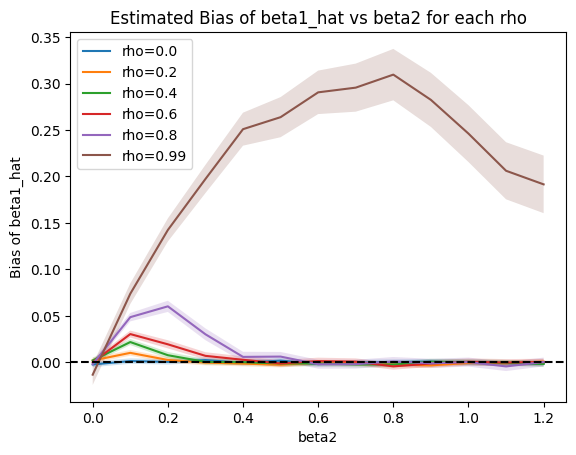

In [22]:
for i, rho in enumerate(rhos):
    plt.plot(beta2s, bias[i], label=f"rho={rho}")
    plt.fill_between(beta2s, bias_ci_low[i], bias_ci_high[i], alpha=0.2)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("beta2")
plt.ylabel("Bias of beta1_hat")
plt.title("Estimated Bias of beta1_hat vs beta2 for each rho")
plt.legend()
plt.show()

In [27]:
sig = (bias_ci_low > 0) | (bias_ci_high < 0)

print("Bias statistically significant (CI does not contain 0):")
for i, rho in enumerate(rhos):
    idx = np.where(sig[i])[0]

    if len(idx) == 0:
        continue
    
    ranges = []
    start = idx[0]
    prev = idx[0]
    for k in idx[1:]:
        if k == prev + 1:
            prev = k
        else:
            ranges.append((beta2s[start], beta2s[prev]))
            start = k
            prev = k
    ranges.append((beta2s[start], beta2s[prev]))
    pretty_print = ", ".join([f"{a:.2f}-{b:.2f}" if a != b else f"{a:.2f}" for a, b in ranges])
    print(f"rho={rho}: beta2 in {pretty_print}")

Bias statistically significant (CI does not contain 0):
rho=0.2: beta2 in 0.10, 0.90
rho=0.4: beta2 in 0.10-0.20
rho=0.6: beta2 in 0.10-0.30, 0.80
rho=0.8: beta2 in 0.10-0.50
rho=0.99: beta2 in 0.00-1.20


## b

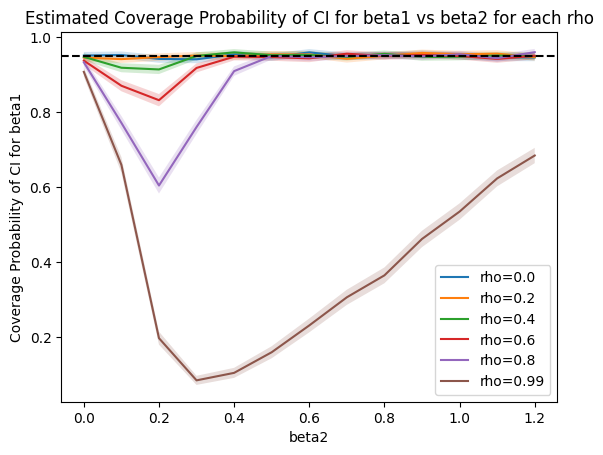

In [23]:
for i, rho in enumerate(rhos):
    plt.plot(beta2s, coverage_prob[i], label=f"rho={rho}")
    plt.fill_between(beta2s, coverage_prob_ci_low[i], coverage_prob_ci_high[i], alpha=0.2)
plt.axhline(1 - alpha, color='black', linestyle='--')
plt.xlabel("beta2")
plt.ylabel("Coverage Probability of CI for beta1")
plt.title("Estimated Coverage Probability of CI for beta1 vs beta2 for each rho")
plt.legend()
plt.show()

The simulation results show that empirical coverage remains close to nominal
95% level when the correlation between regressors is low, but deteriorates 
extremely as correlation increases. When $\rho$ is small (0, 0.2), omitting $X_2$ 
does not introduce substantial bias in $\hat{\beta}_1$. However, as $\rho$ increases
to values such as 0.4 and 0.6, $\beta_2$ becomes large enough to impact the model,
but not always large enough to always be selected. Thus, bias is only introduced
when the "short" model is selected. We can see the issue worsen as $\rho$ gets 
extremely large (0.8, 0.99), and undercoverage becomes severe. The effect is
lessened however as $\beta_2$ grows large at large $\rho$, the full model is
always selected and coverage returns toward the nominal level. 

## c

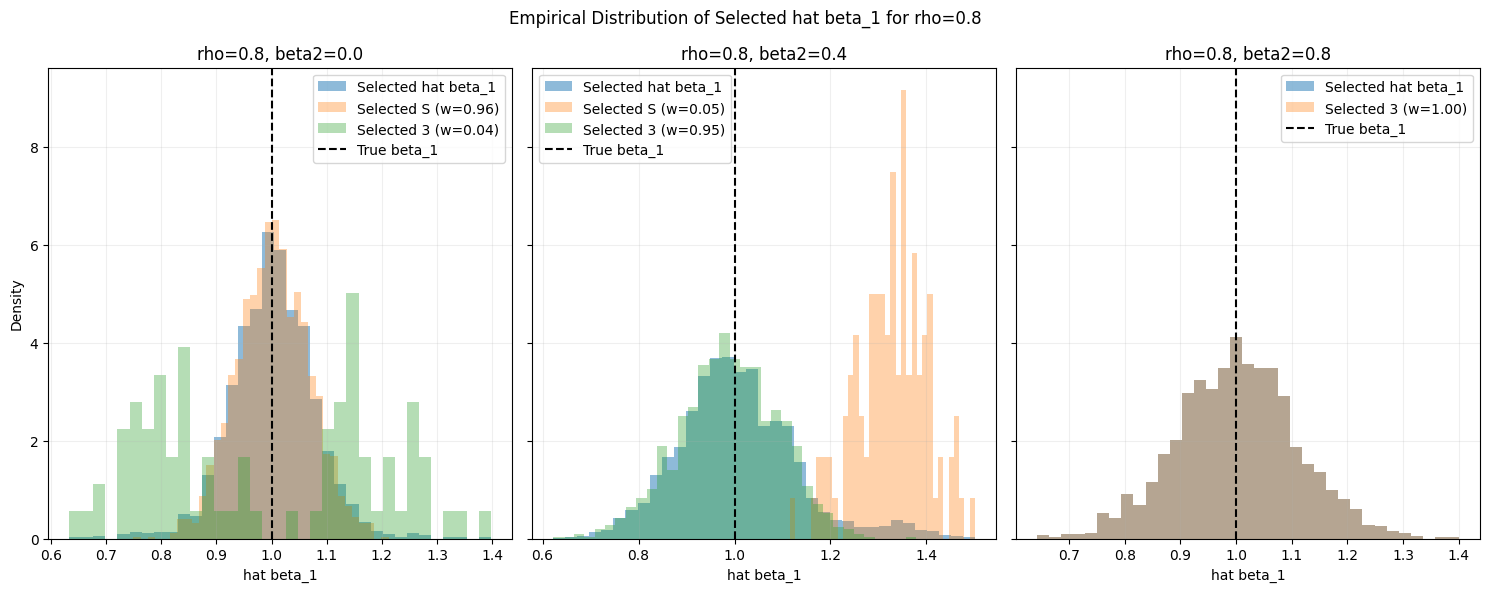

In [37]:
rho = 0.8
beta2s = np.array([0.0, 0.4, 0.8])

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, beta2 in zip(axes, beta2s):
    b1_hat = np.empty(N)
    b1_S = np.empty(N)
    b1_3 = np.empty(N)
    sel3 = np.zeros(N, dtype=bool)

    for r in range(N):
        X1, X2 = generate_X(n, rho, rng)
        y = generate_Y(X1, X2, beta1, beta2, sigma2, rng)

        # model S
        XS = X1.reshape(n, 1)
        resS = sm.OLS(y, XS).fit()
        b1_S[r] = resS.params[0]

        # model 3
        X3 = np.column_stack([X1, X2])
        res3 = sm.OLS(y, X3).fit()
        b1_3[r] = res3.params[0]
        sel3[r] = (res3.pvalues[1] < alpha)

        # selected model
        b1_hat[r] = b1_3[r] if sel3[r] else b1_S[r]

    w3 = sel3.mean()
    wS = 1 - w3

    bins = 35
    ax.hist(b1_hat, bins=bins, density=True, alpha=0.5, edgecolor="none", label="Selected hat beta_1")

    if wS > 0:
        ax.hist(b1_hat[~sel3], bins=bins, density=True, alpha=0.35, edgecolor="none", label=f"Selected S (w={wS:.2f})")
    
    if w3 > 0:
        ax.hist(b1_hat[sel3], bins=bins, density=True, alpha=0.35, edgecolor="none", label=f"Selected 3 (w={w3:.2f})")

    ax.axvline(beta1, color='black', linestyle='--', label="True beta_1")
    ax.set_title(f"rho={rho}, beta2={beta2}")
    ax.set_xlabel("hat beta_1")
    ax.legend()
    ax.grid(True, alpha=0.2)

axes[0].set_ylabel("Density")
plt.suptitle("Empirical Distribution of Selected hat beta_1 for rho=0.8")
plt.tight_layout()
plt.show()

The selected estimator from algorithm 1 is literally model 3 if the t-test
rejects the null hypothesis of beta2 = 0 (if p < $\alpha$), otherwise it selects
model 1. Thus, its sampling distribution is a mixture of the two distributions
where the mixture weight is the probability that p < $\alpha$, and in the simulation
is estimated by the selection frequency `sel3.mean()`. Consequently, this weight
increases when $\beta_2$ is larger, which we can see occur as $\beta_2$ increases.
We can see that when $\beta_2 = 0$, the full model is only selected around 4% of
the time so $\hat{\beta}_1$ is almot entirely the reduced model estimator. With
$\beta_2 = 0.4$, selection is unstable and heavily tilted towards the full model.
However, the reduced model estimator has omitted variable bias, which is why we
see a noticeable different peak in the distribution compared to the roughly
normal distributions of the previous graph. Lastly, when $\beta_2 = 0.8$, the full
model is always selected, thus the mixture collpases to a single component
and the distribution is roughly normal around $\beta_1$.

## d

It seems counterintuitive as in the full model OLS for $\beta_1$ is unbiased
regardless of whether $\beta_2$ is zero or not. The bias comes from the selection
step, as the expectation is:
$$
E[\hat{\beta}_1] = wE[\hat{\beta}_1^{(3)}] + (1 - w)E[\hat{\beta}_1^{(S)}]
$$
The full model estimator is unbiased as $E[\hat{\beta}_1^{(3)}] = \beta_1$, but
the reduced model suffers omitted variable bias as $E[\hat{\beta}_1^{(S)}] = \beta_1 + \beta_2\rho$.
Thus, the expectation is:
$$
E[\hat{\beta}_1] = \beta_1 + (1 - w)\beta_2\rho
$$
and the bias is consequently:
$$
\text{Bias}(\hat{\beta}_1) = (1 - w)\beta_2\rho
$$

Thus, we can see how the mixture argument from part c applies here, as the bias
stems from mixing an unbiased estimator (full) with the a biased one (reduced),
where the mixing weight depends onthe magnitude of $\beta_2$.